In [49]:
import re
import glob
from pathlib import Path

def last_log_likelihood(path):
    path = Path(path)
    text = path.read_text()
    # Find header line containing 'Estimated Log Likelihood' and parse following numeric rows.
    lines = text.splitlines()
    header_idx = None
    for i, l in enumerate(lines):
        if 'Estimated Log Likelihood' in l:
            header_idx = i
            break
    pat = re.compile(r'^\s*(\d+)\s+([-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?\d+)?)')
    vals = []
    if header_idx is not None:
        for l in lines[header_idx+1:]:
            m = pat.match(l)
            if m:
                # Group 2 is the numeric log likelihood value
                vals.append(float(m.group(2)))
            # stop if we hit the section that writes files
            if l.strip().startswith('Writing to file'):
                # continue scanning in case more numeric rows exist, but it's okay to continue
                continue
    else:
        # fallback: scan whole file for iteration-number rows
        for l in lines:
            m = pat.match(l)
            if m:
                vals.append(float(m.group(2)))
    return vals[-1] if vals else None

# Parse all *.output.txt files in current directory
results = {}
for fp in sorted(glob.glob('*.output.txt')):
    try:
        model = fp.split('.')[0]
        states = model.split('_')[1]
        # print(states)
        results[states] = last_log_likelihood(fp)
    except Exception as e:
        results[states] = f'ERROR: {e}'

# Display results nicely
from pprint import pprint
# pprint(results)

In [50]:
import pandas as pd
# print(results)
df = pd.DataFrame.from_dict(results, orient='index')
df = df.reset_index()
df.columns = ['States', 'Log Likelihood']
df['States'] = pd.to_numeric(df['States'], errors='coerce')
sorted_df = df.sort_values('States')
print(sorted_df)

    States  Log Likelihood
0        1   -3.421702e+07
11       2   -2.426731e+07
18       3   -2.004688e+07
19       4   -1.770100e+07
20       5   -1.619032e+07
21       6   -1.502432e+07
22       7   -1.473698e+07
23       8   -1.437231e+07
24       9   -1.398541e+07
1       10   -1.387268e+07
2       11   -1.369595e+07
3       12   -1.354089e+07
4       13   -1.335621e+07
5       14   -1.319875e+07
6       15   -1.313619e+07
7       16   -1.307979e+07
8       17   -1.303906e+07
9       18   -1.298498e+07
10      19   -1.296557e+07
12      20   -1.293060e+07
13      21   -1.290154e+07
14      22   -1.288732e+07
15      23   -1.284011e+07
16      24   -1.282767e+07
17      25   -1.281606e+07


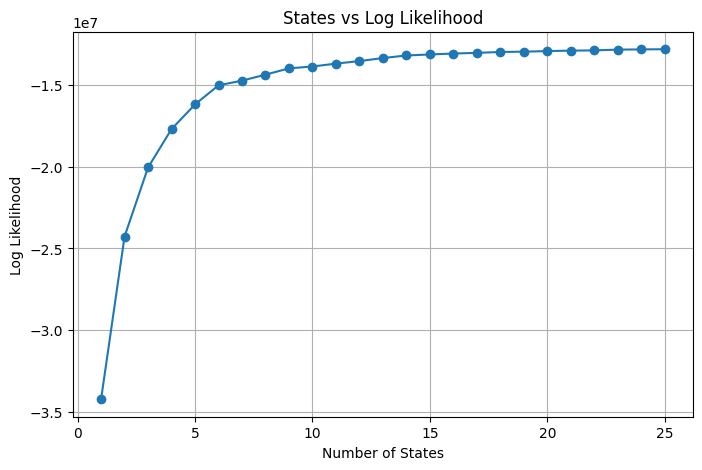

In [51]:
import matplotlib.pyplot as plt

# Plot log likelihood by number of states
plt.figure(figsize=(8,5))
plt.plot(sorted_df["States"], sorted_df["Log Likelihood"], marker='o')
plt.xlabel("Number of States")
plt.ylabel("Log Likelihood")
plt.title("States vs Log Likelihood")
plt.grid(True)
plt.show()


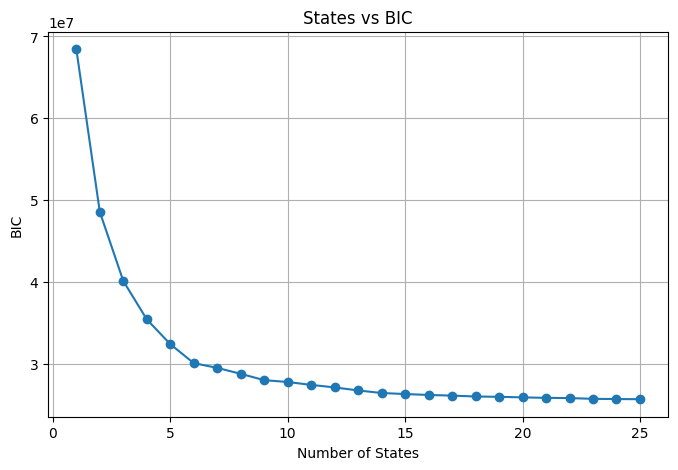

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# calculate BIC 

M = 6
bin_size = 200
hg19 = 45841531
mm10 = 27293334

n = hg19 // bin_size  # number of bins in hg19
S = sorted_df["States"].values
logL = sorted_df["Log Likelihood"].values

# Parameter count k(S) = emission + transition + initial
k = S * M + S * (S - 1) + (S - 1)

bic = -2 * logL + k * np.log(n)

sorted_df["k"] = k
sorted_df["BIC"] = bic


plt.figure(figsize=(8,5))
plt.plot(sorted_df["States"], sorted_df["BIC"], marker='o')
plt.xlabel("Number of States")
plt.ylabel("BIC")
plt.title("States vs BIC")
plt.grid(True)
plt.show()


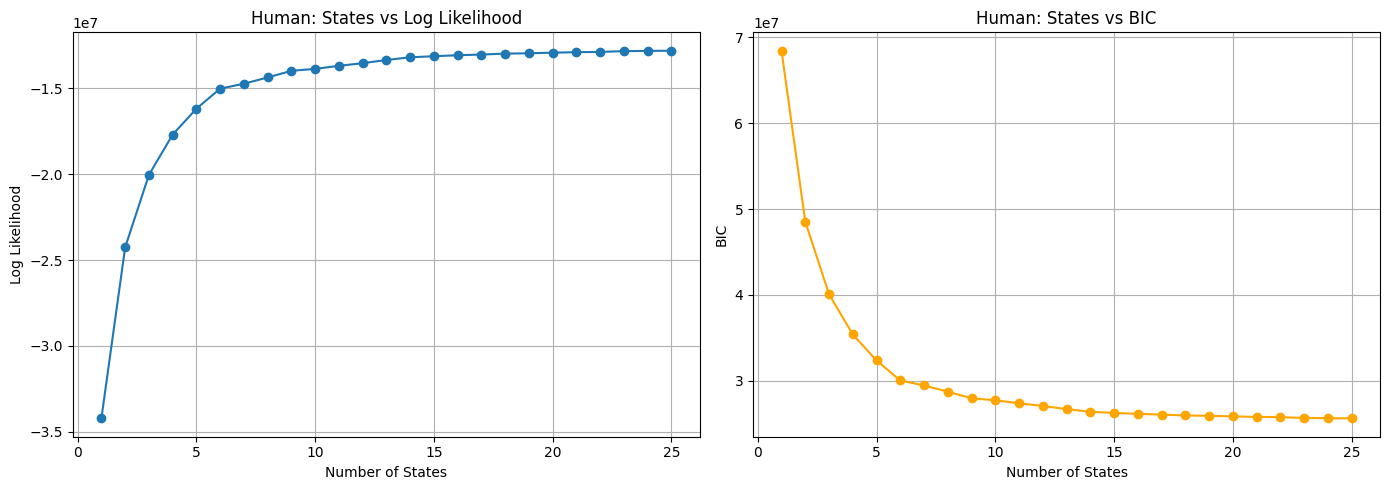

In [54]:
import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# --- Left plot: Log Likelihood ---
axes[0].plot(sorted_df["States"], sorted_df["Log Likelihood"], marker='o')
axes[0].set_xlabel("Number of States")
axes[0].set_ylabel("Log Likelihood")
axes[0].set_title("Human: States vs Log Likelihood")
axes[0].grid(True)

# --- Right plot: BIC ---
axes[1].plot(sorted_df["States"], sorted_df["BIC"], marker='o', color='orange')
axes[1].set_xlabel("Number of States")
axes[1].set_ylabel("BIC")
axes[1].set_title("Human: States vs BIC")
axes[1].grid(True)

plt.tight_layout()
plt.show()
